In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.signal as signal

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.log_config import configure_logging
from src.plots.confidence_intervals import (
    create_confidence_intervals,
    plot_confidence_intervals,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [4]:
# Get data
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )
df

trial_id,trial_number,participant_id,timestamp,temperature,rating,eda_raw,eda_tonic,eda_phasic,ppg_raw,ppg_ibi_shimmer,heartrate,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil_mean,pupil_mean_tonic,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
23,1,3,184809.3687,0.0,0.93625,3.855469,4.417003,-0.561535,1318.503562,-2.847329,69.330443,4.021351,4.492471,4.491222,4.022056,4.256639,4.309533,0.00008,0.00185,0.00251,0.0033,0.01223,0.0,658,null,0,0,111,111,67,0,0
23,1,3,184909.3687,0.000081,0.93625,3.87526,4.434407,-0.559147,1427.801949,-0.98335,69.314627,4.041885,4.502159,4.50269,4.0408,4.271745,4.316037,0.000037,0.000965,0.001661,0.001437,0.006411,100.0,658,null,0,0,111,111,67,0,0
23,1,3,185009.3687,0.000325,0.93625,3.897236,4.453884,-0.556648,1488.690007,0.783387,69.24965,4.059964,4.527155,4.527178,4.061328,4.294253,4.322598,0.000047,0.000486,0.001811,0.000719,0.006277,200.0,658,null,0,0,111,111,67,0,0
23,1,3,185109.3687,0.000887,0.93625,3.916581,4.472846,-0.556266,1459.485729,-5.07083,69.105468,4.087014,4.564178,4.563636,4.085616,4.324626,4.328764,0.00004,0.000528,0.000901,0.002076,0.006666,300.0,658,null,0,0,111,111,67,0,0
23,1,3,185209.3687,0.001743,0.93625,3.940876,4.489759,-0.548884,1433.276657,3.82947,68.885211,4.127938,4.581748,4.582575,4.12897,4.355773,4.334565,0.000049,0.000496,0.000628,0.001315,0.007096,400.0,658,null,0,0,111,111,67,0,0
23,1,3,185309.3687,0.0029,0.93625,3.973437,4.507247,-0.53381,1409.203397,-5.340423,68.558235,4.185911,4.589515,4.58934,4.186352,4.387846,4.339762,0.00001,0.000251,0.000542,0.000527,0.003068,500.0,658,null,0,0,111,111,67,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
513,12,50,2.6956e6,0.031312,0.0,26.688608,26.716225,0.003169,1323.813266,-5.036073,59.279672,5.166699,4.766597,4.768156,5.167254,4.967705,5.180142,0.000465,0.001124,0.007081,0.00022,0.004168,179500.0,806,null,2565,1539,0,0,0,0,0
513,12,50,2.6957e6,0.030874,0.0,26.68499,26.716212,0.000389,1244.871959,44.337204,58.673362,5.026438,4.683481,4.690238,5.025632,4.857935,5.174284,0.000698,0.000846,0.007044,0.000348,0.004289,179600.0,806,null,2565,1539,0,0,0,0,0


In [5]:
signals = [
    "temperature",
    "rating",
    "heartrate",
    "pupil_mean",
    "pupil_mean_tonic",
    "eda_tonic",
    "eda_phasic",
]

In [6]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=signals,
    groupby="trial_id",
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'b83c0c5f-12df-4c4e-b2fc-3b86a4276a9f': {'version…

In [13]:
conf = create_confidence_intervals(
    df,
    signals,
    bin_size=0.1,
    scaling="min_max",
    confidence_level=0.95,
)
plot_confidence_intervals(conf, signals)

BokehModel(combine_events=True, render_bundle={'docs_json': {'d9305c39-2157-4bb1-b26f-67116141848c': {'version…

(-0.010833333333333334, 0.08084309531806697)

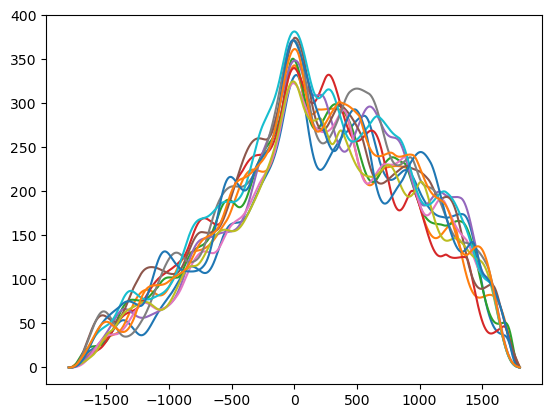

In [ ]:
col1 = "avg_temperature"
col2 = "avg_eda_tonic"

lag_arr = []
stimulus_seed = []
for stimulus in conf.get_column("stimulus_seed").unique(maintain_order=True).to_numpy():
    temperature = conf.filter(stimulus_seed=stimulus)[col1].to_numpy()
    rating = conf.filter(stimulus_seed=stimulus)[col2].to_numpy()

    # Cross-correlation
    corr = signal.correlate(
        temperature,
        rating,
        method="auto",
    )
    # Lag indices for the cross-correlation with 0 at the center
    lags = signal.correlation_lags(
        len(temperature),
        len(rating),
    )
    plt.plot(lags, corr)

    # Find the maximum correlation and the lag
    lag = lags[np.argmax(corr)] * 10 / 1000  # ms to s
    lag_arr.append(lag)
    stimulus_seed.append(stimulus)

lag_arr = np.array(lag_arr)
lag_df = pl.DataFrame({"stimulus_seed": stimulus_seed, "lag": lag_arr})

lag_df["lag"].mean(), lag_df["lag"].std()

In [37]:
lag_df

stimulus_seed,lag
u16,f64
133,0.02
243,0.0
265,-0.01
396,0.0
467,0.01
658,0.01
681,-0.01
743,0.0
806,-0.01
